In [3]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load
from tqdm import tqdm
from wandb.sklearn import plot_learning_curve
from sklearn.model_selection import GridSearchCV
import time

MODEL_OUTPUT_PATH = "../src/models/"
SCALER_OUTPUT_PATH = "../src/scaler/"

# Overall Cyber Risk Prediction

## Data Generation

In [4]:
columns = ['Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Number of Employees', 'Employee Training', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
LEVELS = ['LOW', 'MEDIUM', 'HIGH']
ADVISOR = ['YES', 'NO']
prediction_result_mapping = {0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

In [4]:
def generate_data(nr_entries = 1000, min_empl = 30, max_empl = 10000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in tqdm(range(0, nr_entries)):
        nr_employees = random.randint(min_empl, max_empl)
        employees_training = random.choice(LEVELS)
        
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = random.choice(ADVISOR)

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = invested_perc - (succ_attack / nr_attacks) + (nr_employees / max_empl) * LEVELS.index(employees_training) - (known_vulnerabilities / max_nr_vulnerabilities) + ADVISOR.index(external_adv)
                
        df.loc[i] = [invested_amount, succ_attack, failed_attack, business_value, nr_employees, employees_training, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, low_medium_boundary = 1.0, medium_high_boundary = 0.0):
  if weighted_risk >= low_medium_boundary:
      return "LOW"
  elif weighted_risk >= medium_high_boundary and weighted_risk < low_medium_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [23]:
data = generate_data(nr_entries = 10000)
#data = pd.read_csv('./overall_cyber_data.csv')
#data.pop('Unnamed: 0')

0            0
1            1
2            2
3            3
4            4
         ...  
99995    99995
99996    99996
99997    99997
99998    99998
99999    99999
Name: Unnamed: 0, Length: 100000, dtype: int64

In [24]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,1147297,38,5,5058467,52608,MEDIUM,0,NO,MEDIUM
1,1320806,29,15,4909813,88397,LOW,3,YES,HIGH
2,719662,46,19,4944962,53330,MEDIUM,3,NO,HIGH
3,794910,39,39,4989944,69107,MEDIUM,5,YES,HIGH
4,1198383,46,38,5028979,2343,HIGH,2,NO,HIGH


In [25]:
data.describe()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Known Vulnerabilities
count,1.000000e+05,100000.000000,100000.000000,1.000000e+05,100000.00000,100000.000000
mean,7.496665e+05,24.489200,24.520900,4.999977e+06,45085.32415,4.501340
std,4.327537e+05,14.433206,14.407783,4.995753e+04,25986.14102,2.873437
min,1.300000e+01,0.000000,0.000000,4.780767e+06,31.00000,0.000000
25%,3.749590e+05,12.000000,12.000000,4.966252e+06,22549.50000,2.000000
50%,7.481770e+05,25.000000,25.000000,5.000026e+06,45001.00000,4.000000
75%,1.125106e+06,37.000000,37.000000,5.033557e+06,67689.25000,7.000000
max,1.543092e+06,49.000000,49.000000,5.197066e+06,90000.00000,9.000000


### Data Export as .csv

In [ ]:
data.to_csv('overall_cyber_data.csv')

# Data Processing

## Categorization Step

In [26]:
start = time.time()

levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})

stop = time.time()
print(f"Categorization time: {stop - start}s")

Categorization time: 0.12056803703308105s


In [27]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,1147297,38,5,5058467,52608,1,0,0,1
1,1320806,29,15,4909813,88397,0,3,1,2
2,719662,46,19,4944962,53330,1,3,0,2
3,794910,39,39,4989944,69107,1,5,1,2
4,1198383,46,38,5028979,2343,2,2,0,2


## Normalization Step - using scaler

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Used for the scikit models
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Normalized Splitted X Data
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [45]:
dump(scaler, SCALER_OUTPUT_PATH + 'MinMaxScaler.joblib') 

['../src/scaler/MinMaxScaler.joblib']

In [46]:
scaler.scale_

array([6.48054960e-07, 2.04081633e-02, 2.04081633e-02, 2.44227082e-06,
       1.11149396e-05, 5.00000000e-01, 1.11111111e-01, 1.00000000e+00])

# Decision Tree Classifier

In [35]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

In [36]:
dtree = DecisionTreeClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [38]:
# Define the parameter ranges that should be tested on the model
dtree_params = {
    'criterion': ["gini", "entropy"],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Instanciate the Grid for parameter tuning
dtree_grid = GridSearchCV(dtree, dtree_params, cv=5, scoring='accuracy', n_jobs=-1)

dtree = dtree_grid.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [39]:
pd.DataFrame(dtree.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055412,0.006636,0.002142,0.000733,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.606062,0.606,0.606,0.606,0.606,0.606012,0.000025,1153
1,0.049063,0.007152,0.001265,0.000293,gini,1,1,3,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.606062,0.606,0.606,0.606,0.606,0.606012,0.000025,1153
2,0.060620,0.010399,0.001584,0.000385,gini,1,1,4,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.606062,0.606,0.606,0.606,0.606,0.606012,0.000025,1153
3,0.064092,0.004912,0.002341,0.001135,gini,1,1,5,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.606062,0.606,0.606,0.606,0.606,0.606012,0.000025,1153
4,0.066012,0.008202,0.001823,0.000799,gini,1,1,6,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.606062,0.606,0.606,0.606,0.606,0.606012,0.000025,1153


In [40]:
print(dtree.best_estimator_)
print(dtree.best_params_)
print('Best Accuracy: {0:.2%}'.format(dtree.best_score_))

DecisionTreeClassifier(max_depth=9, min_samples_leaf=5)
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best Accuracy: 92.17%


## (Train - using Test-Train Split)

In [ ]:
#start = time.time()

#dtree.fit(X_train, y_train) 

#stop = time.time()
#print(f"Training time for Decision Tree Classifier: {stop - start}s")

## Evaluate

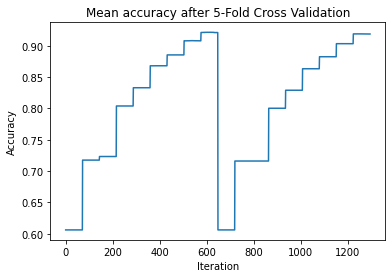

In [41]:
test_scores = dtree.cv_results_['mean_test_score']

plt.title("Mean accuracy after 5-Fold Cross Validation")
plt.plot(test_scores)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [43]:
accuracy = dtree.score(X_test, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 92.64%


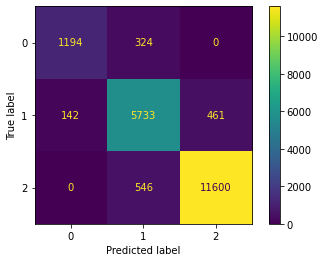

In [42]:
plot_confusion_matrix(dtree, X_test, y_test)  
plt.show()

## Export

In [44]:
#r = export_text(dtree.best_estimator_, feature_names=features)
#print(r)

dump(dtree, MODEL_OUTPUT_PATH + 'Tree_classifier.joblib') 

['../src/models/Tree_classifier.joblib']

## Prediction

In [47]:
# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]], columns=features)
prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,1077113,8,29,4947796,57879,1,6,0


In [48]:
predicted_risk = dtree.predict(prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Support Vector Machine (SVM) classifier

In [50]:
from sklearn.svm import LinearSVC, SVC 

## Parameter Tuning (with K-Fold Cross Validation)

In [51]:
# Define the parameter ranges that should be tested on the model
svm_params = {
    'kernel': ["poly", "rbf", "sigmoid"],
    'gamma': ["scale", "auto"]
}

# Instanciate the Grid for parameter tuning
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)

svm = svm_grid.fit(X_train_normalized, y_train)

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [52]:
pd.DataFrame(svm.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13.381216,1.490621,1.792910,0.120235,scale,poly,"{'gamma': 'scale', 'kernel': 'poly'}",0.990125,0.988875,0.987500,0.988875,0.990437,0.989162,0.001047,2
1,23.718287,1.045816,14.939887,0.280658,scale,rbf,"{'gamma': 'scale', 'kernel': 'rbf'}",0.992062,0.993812,0.991688,0.992062,0.992625,0.992450,0.000744,1
2,192.282993,13.707354,37.752958,1.490174,scale,sigmoid,"{'gamma': 'scale', 'kernel': 'sigmoid'}",0.589625,0.587313,0.582688,0.585875,0.531687,0.575437,0.021990,6
3,64.416836,7.084646,13.422380,0.752963,auto,poly,"{'gamma': 'auto', 'kernel': 'poly'}",0.960812,0.962375,0.959438,0.960500,0.961063,0.960838,0.000948,4
4,59.359830,2.038722,34.013328,0.910545,auto,rbf,"{'gamma': 'auto', 'kernel': 'rbf'}",0.982313,0.987000,0.984500,0.983125,0.985375,0.984463,0.001654,3


In [53]:
print(svm.best_estimator_)
print(svm.best_params_)
print('Best Accuracy: {0:.2%}'.format(svm.best_score_))

SVC()
{'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 99.25%


## (Train - using Test-Train Split)

In [452]:
# Linear
#svm_model = LinearSVC().fit(X_train, y_train)

#start = time.time()

#svm.fit(X_train_normalized, y_train)

#stop = time.time()
#print(f"Training time for polynomial SVM: {stop - start}s")

## Evaluate

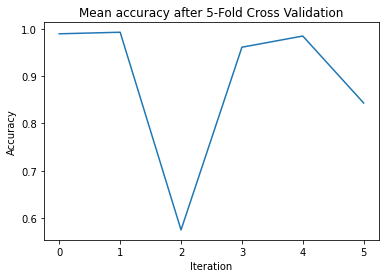

In [54]:
test_scores = svm.cv_results_['mean_test_score']

plt.title("Mean accuracy after 5-Fold Cross Validation")
plt.plot(test_scores)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [56]:
accuracy = svm.score(X_test_normalized, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 99.30%


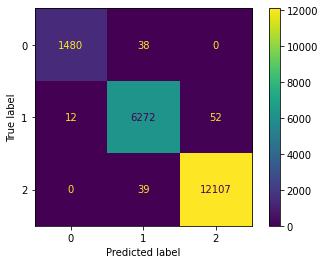

In [57]:
plot_confusion_matrix(svm, X_test_normalized, y_test)  
plt.show()

## Export

In [58]:
dump(svm, MODEL_OUTPUT_PATH + 'SVM_classifier.joblib') 

['../src/models/SVM_classifier.joblib']

## Prediction

In [59]:
predicted_risk = svm.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# K-nearest Neighbours Classifier

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
knn = KNeighborsClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [62]:
# Define the parameter ranges that should be tested on the model
knn_params = {
    'n_neighbors': range(1, 30),
    'weights': ['uniform', 'distance']
}

# Instanciate the Grid for parameter tuning
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy', n_jobs=-1)

knn = knn_grid.fit(X_train_normalized, y_train)

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [63]:
pd.DataFrame(knn.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.347437,0.175149,1.194680,0.083902,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.934625,0.939438,0.938000,0.935438,0.937438,0.936987,0.001744,55
1,0.345715,0.192468,0.804296,0.049448,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.934625,0.939438,0.938000,0.935438,0.937438,0.936987,0.001744,55
2,0.350089,0.216850,1.449993,0.089380,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.930688,0.933063,0.930312,0.929375,0.929312,0.930550,0.001364,58
3,0.344410,0.232399,1.005856,0.090186,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.934625,0.939438,0.938000,0.935438,0.937438,0.936987,0.001744,55
4,0.351998,0.206176,1.558743,0.122715,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.944312,0.948187,0.945875,0.946063,0.946438,0.946175,0.001240,53


In [64]:
print(knn.best_estimator_)
print(knn.best_params_)
print('Best Accuracy: {0:.2%}'.format(knn.best_score_))

KNeighborsClassifier(n_neighbors=23, weights='distance')
{'n_neighbors': 23, 'weights': 'distance'}
Best Accuracy: 96.40%


## (Train - using Test-Train Split)

In [130]:
#start = time.time()

#knn.fit(X_train_normalized, y_train) 

#stop = time.time()
#print(f"Training time KNN Classifier: {stop - start}s")

Training time KNN Classifier: 0.0075609683990478516s


## Evaluate

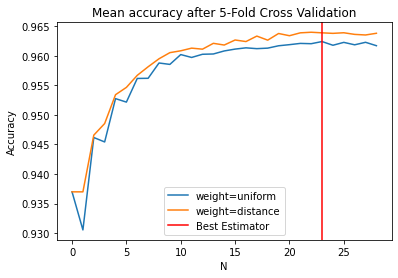

In [65]:
test_scores_weight_uniform = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 0]
test_scores_weight_distance = [ x for ind, x in enumerate(knn.cv_results_['mean_test_score']) if ind % 2 == 1]


plt.title("Mean accuracy after 5-Fold Cross Validation")
plt.plot(test_scores_weight_uniform, label='weight=uniform')
plt.plot(test_scores_weight_distance, label='weight=distance')
plt.axvline(x=knn.best_params_['n_neighbors'], label='Best Estimator', color='r')
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [66]:
accuracy = knn.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 96.44%


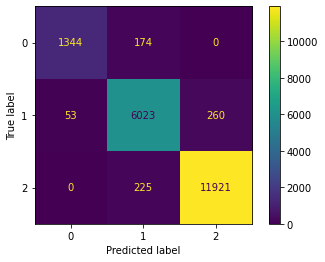

In [67]:
plot_confusion_matrix(knn, X_test_normalized, y_test)  
plt.show()

## Export

In [71]:
dump(knn, MODEL_OUTPUT_PATH + 'KNN_classifier.joblib') 

['../src/models/KNN_classifier.joblib']

## Prediction

In [68]:
predicted_risk = knn.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Multilayer Perceptron (MLP) using Backpropagation

In [69]:
from sklearn.neural_network import MLPClassifier

In [70]:
mlp = MLPClassifier()

## Parameter Tuning (with K-Fold Cross Validation)

In [72]:
mlp_params={
'learning_rate': ["constant", "invscaling", "adaptive"],
'hidden_layer_sizes': [(5, 5)],
'solver': ["lbfgs", "sgd", "adam"],
'activation': ["logistic", "relu", "tanh"]
}

# Instanciate the Grid for parameter tuning
mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='accuracy', n_jobs=-1)

mlp = mlp_grid.fit(X_train_normalized, y_train)

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [73]:
mlp_result = pd.DataFrame(mlp.cv_results_)

mlp_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.603579,0.352732,0.006152,0.002534,logistic,"(5, 5)",constant,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.996812,0.994437,0.989938,0.991563,0.995313,0.993613,0.002511,7
1,27.330389,0.429902,0.008389,0.003694,logistic,"(5, 5)",constant,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.906813,0.914250,0.908000,0.896938,0.907375,0.906675,0.005558,21
2,33.327226,1.903533,0.008772,0.003556,logistic,"(5, 5)",constant,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.995188,0.991313,0.991313,0.990313,0.993000,0.992225,0.001715,8
3,9.149049,0.291416,0.006680,0.001333,logistic,"(5, 5)",invscaling,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.991625,0.979250,0.995563,0.997188,0.973562,0.987438,0.009361,16
4,2.189471,0.143768,0.008473,0.003572,logistic,"(5, 5)",invscaling,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.606062,0.606000,0.606000,0.606000,0.606000,0.606012,0.000025,27


In [74]:
print(mlp.best_estimator_)
print(mlp.best_params_)
print('Best Accuracy: {0:.2%}'.format(mlp.best_score_))

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5),
              learning_rate='invscaling')
{'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'learning_rate': 'invscaling', 'solver': 'adam'}
Best Accuracy: 99.63%


## (Train - Using Test-Train Split)

In [322]:
#start = time.time()

#mlp.fit(X_train_normalized, y_train)

#stop = time.time()
#print(f"Training time MLP Classifier: {stop - start}s")

## Evaluate

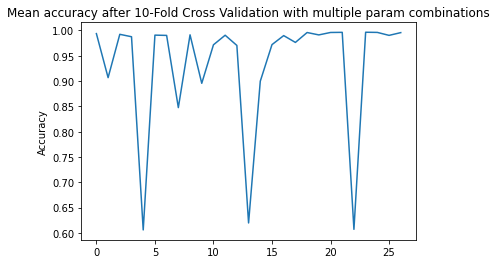

In [75]:
test_scores = mlp.cv_results_['mean_test_score']

plt.title("Mean accuracy after 10-Fold Cross Validation with multiple param combinations")
plt.plot(test_scores)
plt.ylabel("Accuracy")
plt.show()

In [76]:
accuracy = mlp.score(X_test_normalized, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 99.58%


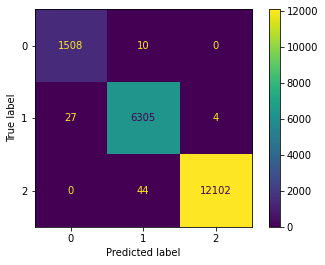

In [77]:
plot_confusion_matrix(mlp, X_test_normalized, y_test)  
plt.show()

In [ ]:
#X = scaler.transform(data[features])
#Y = data["Risk"]
#plot_learning_curve(mlp, X, Y)

## Export

In [79]:
dump(mlp, MODEL_OUTPUT_PATH + 'MLP_classifier.joblib') 

['../src/models/MLP_classifier.joblib']

## Prediction

In [80]:
predicted_risk = mlp.predict(scaler.transform([[1077113, 8, 29, 4947796, 57879, 1, 6, 0]]))[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: MEDIUM


# Benchmarking

In [93]:
dataset_entries = [5000, 10000, 25000, 50000, 100000]
dt_accuracy_list = []
svm_accuracy_list = []
knn_accuracy_list = []
mlp_accuracy_list = []

dt_training_times = []
svm_training_times = []
knn_training_times = []
mlp_training_times = []

In [94]:
for nr_of_entries in dataset_entries:
    data = generate_data(nr_of_entries)
    data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})
    
    X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)
    
    # Decision Tree
    dtree_model = DecisionTreeClassifier()
    start = time.time()
    dtree_model.fit(X_train, y_train) 
    stop = time.time()
    dt_training_times.append(stop - start)
    dt_accuracy_list.append(dtree_model.score(X_test, y_test))
                            
    # Scaler
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    # SVM
    svm_model = SVC(kernel='poly')
    start = time.time()
    svm_model.fit(X_train_normalized, y_train)
    stop = time.time()
    svm_training_times.append(stop - start)
    svm_accuracy_list.append(svm_model.score(X_test_normalized, y_test))
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 17)
    start = time.time()
    knn.fit(X_train_normalized, y_train) 
    stop = time.time()
    knn_training_times.append(stop - start)
    knn_accuracy_list.append(knn.score(X_test_normalized, y_test))
    
    # MLP
    clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=100000)
    start = time.time()
    clf.fit(X_train_normalized, y_train)
    stop = time.time()
    mlp_training_times.append(stop - start)
    mlp_accuracy_list.append(clf.score(X_test_normalized, y_test))
    

In [100]:
print(dataset_entries)
print("\n Accuracy:")
print("Decision Tree: " + str(dt_accuracy_list))
print(svm_accuracy_list)
print(knn_accuracy_list)
print(mlp_accuracy_list)

print("\n Training Times:")
print(dt_training_times)
print(svm_training_times)
print(knn_training_times)
print(mlp_training_times)

[5000, 10000, 25000, 50000, 100000]

 Accuracy:
Decision Tree: [0.8784, 0.9048, 0.92896, 0.93928, 0.9508]
[0.9664, 0.9772, 0.98528, 0.98728, 0.98984]
[0.9168, 0.9332, 0.9496, 0.95544, 0.96436]
[0.9888, 0.9972, 0.99824, 0.97256, 0.9992]

 Training Times:
[0.010490179061889648, 0.0204160213470459, 0.05765199661254883, 0.12712311744689941, 0.3110668659210205]
[0.06813311576843262, 0.19890880584716797, 0.8305602073669434, 3.1285979747772217, 12.188233137130737]
[0.0017361640930175781, 0.004775047302246094, 0.0270688533782959, 0.054738759994506836, 0.365800142288208]
[8.24178409576416, 11.813431978225708, 30.678292989730835, 13.996891021728516, 540.4573841094971]
